In [1]:
import pandas as pd
import re
import sklearn as sk
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# NLP
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
import gensim
import gensim.downloader as gdownload

# deep learning
import tensorflow as tf
import keras
from keras import layers
print(tf.config.list_physical_devices('GPU')) # check if gpu is detected
from keras import backend as K
import gc

# visualization
import datetime
import matplotlib.pyplot as plt
from IPython.display import display
# tensorboard
%load_ext tensorboard

[nltk_data] Downloading package wordnet to /home/ashkan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ashkan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2023-08-28 01:16:24.418295: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-28 01:16:25.210870: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-28 01:16:25.840320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
# preprocessin funcs
# preprocessing functions

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

def multiple_replace(arr, replace, source):
    for item in arr:
        source = re.sub(item, replace, source)

    return source

def preprocess_txt(txt):
    set_stopwords = set(stopwords.words('english'))
    
    # replace stuff
    txt = re.sub(r'\b\S*[\x80-\xFF]\S*\b', ' ', txt) # any words with non-ascii characters
    txt = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', ' url ', txt) # urls
    txt = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,7}\b', ' email ', txt) # emails
    txt = re.sub(r'<.*?>', ' ', txt) # remove html tags completely
    txt = re.sub(r'&.*?;', ' ', txt) # remove HTML entities
    txt = re.sub(r'#', ' ', txt) # hastags --> just remove the tag
    txt = re.sub(r'\b\d+\b', ' num ', txt) # numbers
    txt = re.sub(r'[^\w\s]', r' \g<0> ', txt) # punctuation
    
    # lowercase
    txt = txt.lower()

    # https://saturncloud.io/blog/reshaping-text-data-for-lstm-models-in-keras-a-comprehensive-guide/

    # split
    # nltk handles all punctuation as features
    word_arr = re.split(f'\s+', txt) # returns list of words

    # remove stopwords and drop empty strings
    word_arr = [word for word in word_arr if word not in set_stopwords and len(word) != 0]
    
    # lemmatize
    lemmatizer = nltk.stem.WordNetLemmatizer()
    word_arr = [lemmatizer.lemmatize(word) for word in word_arr]

    return word_arr

def preprocess_txt_list(txt_list, embedding, sequence_length):

    processed_tweets = []
    for i, txt in enumerate(txt_list):
        
        # DEBUG
        try:
           _ = txt.lower()
        except:
           "Empty string found"
           txt = ""

        word_list = preprocess_txt(txt)
        processed_tweets.append(word_list)
                                    
        if i % 10000 == 0: # log the processed message in specified intervals
            print(f"Processed text #{i}:", word_list)
            print("---------------------------")        
    
    # tokenize (I ditched the old tokenizer)
    print("tokenizing...")
    embedding_length = len(embedding)
    # convert each word to its index. if it doesn't exist, set it to the last index. I don't care that it ruins one word's meaning
    tokenized = [[embedding.key_to_index[word] if word in embedding else (embedding_length - 1) for word in split_sentence] for split_sentence in processed_tweets]

    # add padding and convert to numpy array
    print('padding sequences...')
    tokenized = np.asarray(keras.preprocessing.sequence.pad_sequences(
            tokenized,
            padding = 'post',
            maxlen = sequence_length,
    ))

    # DEBUG
    print(tokenized)
    print('feature vector shape:', tokenized.shape)

    return tokenized

# preprocess annotations for initial binary classification
def preprocess_annotations(annotation_list):
    # set all "threat" to 1, the rest to 0
    return np.asarray([1 if x in ["Phishing", "Phishing Email"] else 0 for x in annotation_list])

def train_valid_test_split(ds, train_ratio, valid_ratio):
    # train_ratio = 0.8
    # valid_ratio = 0.1
    init_len = len(ds)
    num_train = np.floor(init_len * train_ratio)
    num_valid = np.floor(init_len * valid_ratio)

    train_ds = ds.take(num_train)
    valid_ds = ds.skip(num_train).take(num_valid)
    test_ds = ds.skip(num_train).skip(num_valid)
    
    print(f'train ds has {num_train} items in {len(train_ds)} batches.')
    print(f'valid ds has {num_valid} items in {len(valid_ds)} batches.')
    print(f'test ds has {init_len - num_train - num_valid} items in {len(test_ds)} batches.')

    return (train_ds, valid_ds, test_ds)

def shuffle(nparr, random_state = 23):
    rng = np.random.RandomState(random_state) # reset the seed
    return rng.permutation(nparr)

def train_and_evaluate(model, train_ds, test_ds, epochs, valid_ds = None):

    print(model.summary())
    history = model.fit(
        train_ds,
        validation_data = valid_ds, # ignored if None
        batch_size = 32,
        epochs = epochs,
        # callbacks = [tensorboard_callback],
    )

    if valid_ds != None:
        # plot losses over time --> shown after training
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('Accuracy')
        plt.xlabel('epoch')
        plt.xlabel('accuracy')
        plt.legend(['train','val'], loc='upper left')
        plt.grid()
        plt.ylim(0.5, 1)
        plt.show()

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Loss')
        plt.xlabel('epoch')
        plt.xlabel('loss')
        plt.legend(['train','val'], loc='upper left')
        plt.grid()
        plt.show()

        plt.plot(history.history['auc'])
        plt.plot(history.history['val_auc'])
        plt.title('PR AUC')
        plt.xlabel('epoch')
        plt.xlabel('AUC')
        plt.legend(['train','val'], loc='upper left')
        plt.grid()
        plt.show()

    # evaluate
    evaluation = model.evaluate(test_ds)
    predictions = [0 if x < 0.5 else 1 for x in model.predict(test_ds)]
    accuracy = evaluation[1]
    test_labels = y = np.concatenate([y for x, y in test_ds], axis=0)

    print("actual labels: ", test_labels) 
    print("predicted labels: ", predictions) 
    print(evaluation) 
    conf_matrix = np.asarray(tf.math.confusion_matrix(test_labels, predictions))

    print("confusion matrix:")
    print(conf_matrix)

    conf_matrix_norm = np.asarray([conf_matrix[idx] / (np.sum(row) + 1e-7) for idx, row in enumerate(conf_matrix)])
    print('confusion matrix (percentage):')
    print(conf_matrix_norm)    

    return (accuracy, model)

# model training funcs + k-fold

def pretrained_embedding(embedding):
    # note: embedding is declared in the previous cell
    
    vocab_size = len(embedding)
    embedding_vector_size = len(embedding[embedding.index_to_key[0]])

    # create embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_vector_size))
    # iterate through embedding and copy word vectors as weights
    for i in range(vocab_size):
        embedding_matrix[i, :] = embedding[embedding.index_to_key[i]]

    embedding_layer = layers.Embedding(input_dim = vocab_size, output_dim = embedding_vector_size, trainable = False)
    embedding_layer.build((None,)) # I have no idea why I should do this
    embedding_layer.set_weights([embedding_matrix]) # square brackets are because some layers take multiple types of weights
    
    return embedding_layer

def build_model(sequence_length, embedding):
  model = keras.Sequential([
    layers.Input(shape = (sequence_length,)),
    pretrained_embedding(embedding),
    # layers.GRU(MAX_TWEET_WORDS, return_sequences=True), # not a difference
    layers.BatchNormalization(),
    layers.Bidirectional(
        layers.GRU(
            sequence_length,
            dropout = 0.2,
        ),
    ),

    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.7),
    layers.Dense(8, activation = 'relu'),
    layers.Dropout(0.7),
    layers.Dense(1, activation = 'sigmoid'),
  ])

  model.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    metrics = [
      'acc',
      keras.metrics.AUC(curve = 'PR', name = 'auc'), # pr curve area - should help with imbalanced data
      # keras.metrics.TruePositives(name = 'tp'),
      # keras.metrics.FalsePositives(name = 'fp'),
      # keras.metrics.TrueNegatives(name = 'tn'),
      # keras.metrics.FalseNegatives(name = 'fn'),
      keras.metrics.Precision(name = 'prec'),
      keras.metrics.Recall(name = 'rec'),
    ],
  )

  return model

def kfold(ds, epochs, batch_size, k, sequence_length, embedding):
  autotune = tf.data.AUTOTUNE

  if k == None:
    # normal stuff
    model = build_model(sequence_length, embedding)

    train_ds, valid_ds, test_ds = train_valid_test_split(ds, 0.6, 0.2)
    train_and_evaluate(
      model,
      train_ds = train_ds,
      valid_ds = valid_ds,
      test_ds = test_ds,
      epochs = epochs,
    )

  else:
    accuracies = []
    for i in range(k):
      print(f'fold {i}')
      
      model = build_model(sequence_length, embedding)
      num_total = len(ds)
      num_test = np.floor(num_total / k)
      num_train = num_total - num_test

      test_range = [np.floor((i) * num_test), np.floor((i + 1) * num_test)]
      train_ds_p1 = ds.take(test_range[0])
      train_ds_p2 = ds.skip(test_range[1])
      train_ds = train_ds_p1.concatenate(train_ds_p2).batch(batch_size).prefetch(autotune)
      print(f'train dataset range: {test_range[0]} - {test_range[1]}')
      test_ds = ds.skip(np.floor((i) * num_test)).take(num_test).batch(batch_size).prefetch(autotune)
      print(f'test dataset range: {test_range[0]} - {test_range[1]}')

      print(f'train ds has {num_train} items in {len(train_ds)} batches.')
      print(f'test ds has {num_test} items in {len(test_ds)} batches.')
      
      accuracy = train_and_evaluate(
        model,
        train_ds,
        test_ds,
        epochs = epochs,
      )[0]
      
      print("accuracy: ", accuracy)
      accuracies.append(accuracy)

    print(f"average accuracy: {np.average(accuracies)}")

In [3]:
# # get the average length of emails
# tweetlengths = df['Email'].apply(lambda x: len(x.split()))
# print(np.average(tweetlengths))

In [4]:
# gdownload.info()

In [5]:
# pre-training data
df_pretrain = pd.read_csv('./pretraining phishing dataset.csv')
display(df_pretrain[20:40])

,Unnamed: 0,Email Text,Email Type
20,20,"re : meeting on feb 8 , 2001 dear mr . nur azm...",Safe Email
21,21,formal invite for chase . secrets revealed . h...,Phishing Email
22,22,\nQuestion?Do you want a different job?\nDo yo...,Phishing Email
23,23,URL: http://www.livejournal.com/talkread.bml?j...,Safe Email
24,24,calpine daily and monthly nomination > > ricky...,Safe Email
25,25,fw : bod agenda deadlines the next bod and com...,Safe Email
26,26,start date : 12 / 16 / 01 ; hourahead hour : 1...,Safe Email
27,27,re : tetco / hpl ( enerfin ) meter # 986892 st...,Safe Email
28,28,\nPROMOTE YOUR PRODUCT OR\nSERVICE TO MILLIONS...,Phishing Email
29,29,culture committee / subcommittee meeting the m...,Safe Email


In [6]:
# embedding = gdownload.load('glove-wiki-gigaword-100') # pretrained embedding --> much cleaner than twitter stuff
# embedding = gdownload.load('glove-twitter-200') # pretrained embedding 
embedding = gdownload.load('glove-twitter-50') # pretrained embedding 
# embedding = gdownload.load('word2vec-google-news-300')
original_texts = np.asarray(df_pretrain['Email Text']) # I'll use this to check the preprocessing process

email_bodies = preprocess_txt_list(df_pretrain['Email Text'], embedding, sequence_length = 80) 
annotation_labels = preprocess_annotations(df_pretrain['Email Type'])

# shuffle the data

###### vvvv SEED IS HERE vvvv ######
# seed = 183
# seed = 89
# seed = 11
# seed = 42
seed = 30
###### ^^^^ SEED IS HERE ^^^^ ######

original_texts = shuffle(original_texts, random_state = seed) # debug
email_bodies = shuffle(email_bodies, random_state = seed)
annotation_labels = shuffle(annotation_labels, random_state = seed)
# type_labels = shuffle(type_labels)

# reduce data for faster training # REMOVE LATER
ratio_keep = 1 
original_texts = original_texts[:int(len(original_texts) * ratio_keep)] # debug
email_bodies = email_bodies[:int(len(email_bodies) * ratio_keep)]
annotation_labels = annotation_labels[:int(len(annotation_labels) * ratio_keep)]
# type_labels = type_labels[:int(len(type_labels) * ratio_keep)]

# DEBUG
def print_list(title, list):
    print(title)
    for i, x in enumerate(list):
        print(f'<<{i}>>', x)
    print("------------------------------------------")

sample_length = 10
print_list("original data:", original_texts[:sample_length])
tokenized_input_sample = [[index for index in x] for x in email_bodies][:sample_length]
print_list("split input: ", [[embedding.index_to_key[index] for index in example] for example in tokenized_input_sample])
print_list("tokenized input: ", tokenized_input_sample)
print("labels: ", annotation_labels[:sample_length])

Processed text #0: [':', 'num', '.', 'num', ',', 'disc', ':', 'uniformitarianism', ',', ':', 'num', ';', 'sex', '/', 'lang', 'dick', 'hudson', "'", 'observation', 'u', 'use', "'", "'", "'", 'aughter', "'", 'vocative', 'thought', '-', 'provoking', ',', 'sure', 'fair', 'attribute', '"', 'son', '"', '"', 'treated', 'like', 'senior', 'relative', '"', '.', 'one', 'thing', ',', 'n', "'", 'normally', 'use', "'", 'brother', "'", 'way', "'", 'aughter', "'", ',', 'hard', 'imagine', 'natural', 'class', 'comprising', 'senior', 'relative', "'", "'", 'excluding', "'", 'brother', "'", '.', 'another', ',', 'seem', 'difference', '.', 'imagining', 'distinction', ',', 'seems', 'senior', 'relative', 'term', 'used', 'wider', 'variety', 'context', ',', 'e', '.', 'g', '.', ',', 'calling', 'distance', 'get', 'someone', "'", 'attention', ',', 'hence', 'beginning', 'utterance', ',', 'whereas', "'", "'", 'seems', 'natural', 'utterance', 'like', "'", 'yes', ',', 'son', "'", ',', "'", 'hand', ',', 'son', "'", 'one

In [12]:
# pre-train model

pretrain_ds = tf.data.Dataset.from_tensor_slices((email_bodies, annotation_labels))
# live_model_train, _, live_model_test = train_valid_test_split(live_model_ds, 0.95, 0, batch_size = 16) # use this for production
pretrain_train, pretrain_valid, pretrain_test = train_valid_test_split(pretrain_ds, 0.8, 0.1) # use for testing

# TEMP
pretrain_train = pretrain_train.batch()
pretrain_valid = pretrain_valid.batch()
pretrain_test = pretrain_test.batch()

# you will get a validation accuracy if it's provided
sequence_length = len(email_bodies[0])
model = build_model(sequence_length, embedding)
# _, model = train_and_evaluate(model, pretrain_train, pretrain_test, epochs = 100) # production
_, model = train_and_evaluate(model, pretrain_train, pretrain_test, epochs = 100, valid_ds = pretrain_valid) # testing
# NOTE: anything after 40 spochs seems to be redundant

model.save('pretrained_binary.keras')

train ds has 14920.0 items in 14920 batches.
valid ds has 1865.0 items in 1865 batches.
test ds has 1865.0 items in 1865 batches.


TypeError: batch() missing 1 required positional argument: 'batch_size'

In [ ]:
# fine-tuning data

df_main = pd.read_csv('./PhishingDataset_HFES2020.csv', encoding='windows-1252')
df_main = df_main.replace('ham', 'Ham') # replace ham with Ham
df_main = df_main[df_main['Email_type'] != 'Attention_check'] # remove Attention_check s
display(df_main.head())
display(df_main['Email_type'].unique())

,Email_ID,Sender,Subject,Email,Email_type
0,1,noreply@powerballs.com,You Have Won!,<p>*********PLEASE DO NOT RESPOND TO THIS EMAI...,Phishing
1,2,noreply@paypalceo.com,PayPal Breach,<p>********* RESPONES TO THIS EMAIL WILL NOT B...,Phishing
2,3,support@credit.chase.com,URGENT: Fraudulent activity detected,"<p>Hello,&nbsp;</p><p>&nbsp;</p><p>We are writ...",Phishing
3,4,mary@yahoo.com,Donations needed for Mark,"<p>Hello,</p><p>&nbsp;</p><p>I&#39;m contactin...",Phishing
4,5,support@security.amazon.com,Your Amazon Account,<p><strong>The account number associated with ...,Phishing


array(['Phishing', 'Ham'], dtype=object)

In [ ]:
# actual preprocessing
original_texts_main = np.asarray(df_main['Email']) # I'll use this to check the preprocessing process

email_bodies_main = preprocess_txt_list(df_main['Email'], embedding, sequence_length = 80) 
annotation_labels_main = preprocess_annotations(df_main['Email_type'])

# shuffle the data

###### vvvv SEED IS HERE vvvv ######
# seed = 183
# seed = 89
# seed = 11
# seed = 42
seed = 30
###### ^^^^ SEED IS HERE ^^^^ ######

original_texts_main = shuffle(original_texts_main, random_state = seed) # debug
email_bodies_main = shuffle(email_bodies_main, random_state = seed)
annotation_labels_main = shuffle(annotation_labels_main, random_state = seed)
# type_labels = shuffle(type_labels)

# reduce data for faster training # REMOVE LATER
ratio_keep = 1 
original_texts_main = original_texts_main[:int(len(original_texts_main) * ratio_keep)] # debug
email_bodies_main = email_bodies_main[:int(len(email_bodies_main) * ratio_keep)]
annotation_labels_main = annotation_labels_main[:int(len(annotation_labels_main) * ratio_keep)]
# type_labels = type_labels[:int(len(type_labels) * ratio_keep)]

# DEBUG
def print_list(title, list):
    print(title)
    for i, x in enumerate(list):
        print(f'<<{i}>>', x)
    print("------------------------------------------")

sample_length = 10
print_list("original data:", original_texts_main[:sample_length])
tokenized_input_sample = [[index for index in x] for x in email_bodies_main][:sample_length]
print_list("split input: ", [[embedding.index_to_key[index] for index in example] for example in tokenized_input_sample])
print_list("tokenized input: ", tokenized_input_sample)
print("labels: ", annotation_labels_main[:sample_length])


Processed text #0: ['*', '*', '*', '*', '*', '*', '*', '*', '*', 'please', 'respond', 'email', '*', '*', '*', '*', '*', '*', '*', '*', '*', 'record', 'show', 'entered', 'win', 'state', 'powerball', 'jackpot', 'num', '/', 'num', '/', 'num', '.', 'receiving', 'email', 'listed', 'one', 'winner', '.', 'claim', 'prize', 'please', 'visit', 'site', 'fill', 'information', 'needed', 'collect', '.', 'must', 'process', 'information', 'within', 'week', 'time', 'may', 'lose', 'winning', '.', 'congratulation', '!', 'collect', 'earnings', '!', 'please', 'click', 'prompt', 'response', 'regarding', 'matter', 'appreciated', '.', 'sincerely', ',', 'powerball', 'team']
---------------------------
tokenizing...
padding sequences...
[[   42    42    42 ...     0     0     0]
 [   42    42    42 ...     0     0     0]
 [  996     4  3145 ...     0     0     0]
 ...
 [  589 31134     4 ...     0     0     0]
 [ 3709     1   416 ...  2471  2311     1]
 [  589     4 11532 ...     0     0     0]]
feature vector 

In [ ]:
# model1_ds = tf.data.Dataset.from_tensor_slices((email_bodies, annotation_labels))
# kfold(
#   ds = model1_ds,
#   epochs = 200,
#   batch_size = 1, 
#   k = None, # anything other than non is broken
#   sequence_length = len(email_bodies[0]),
#   embedding = embedding
# )
# note: I have serious memory leak problems with k-fold.
# I'll use the following seeds to verify the average accuracy:
# 183, 89, 11, 42, 30

train ds has 143.0 items in 143 batches.
valid ds has 47.0 items in 47 batches.
test ds has 49.0 items in 49 batches.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 50)            59675700  
                                                                 
 batch_normalization (Batch  (None, 80, 50)            200       
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 160)               63360     
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                5152      
                                                                 
 dropout (Dropout)           (None, 32)                0         
    

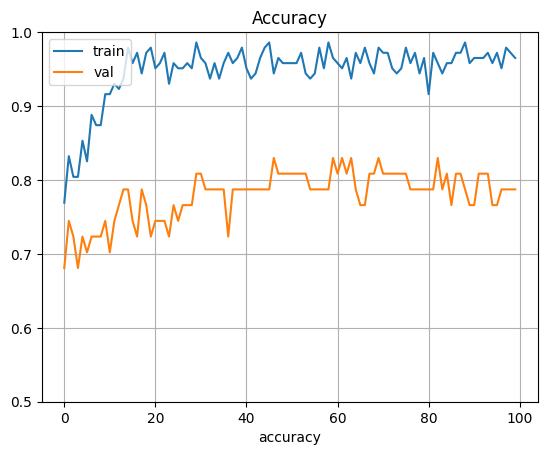

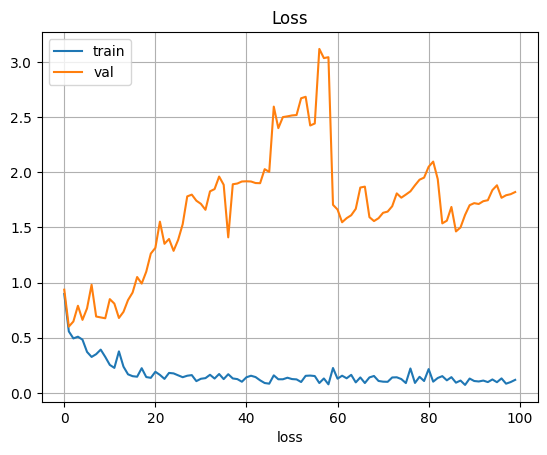

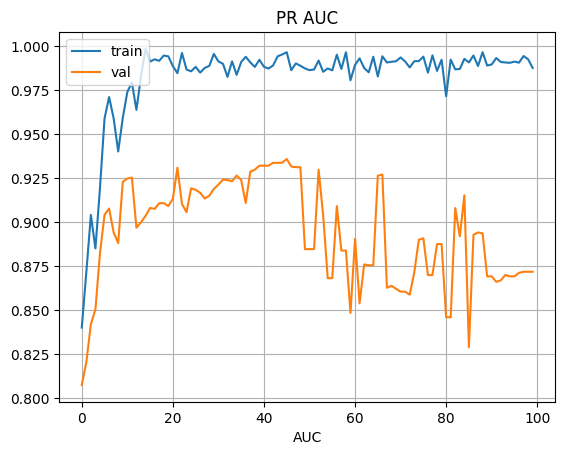

49/49 [==============================] - 1s 7ms/step
actual labels:  [1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
predicted labels:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1.7134904861450195, 0.918367326259613, 0.9276203513145447, 0.9111111164093018, 1.0]
confusion matrix:
[[ 4  4]
 [ 0 41]]
confusion matrix (percentage):
[[0.49999999 0.49999999]
 [0.         1.        ]]


NameError: name 'live_model' is not defined

In [ ]:
# re-train existing model

main_ds = tf.data.Dataset.from_tensor_slices((email_bodies_main, annotation_labels_main))
# main_train, _, main_test = train_valid_test_split(main_ds, 0.8, 0, batch_size = 16) # use this for production
main_train, main_valid, main_test = train_valid_test_split(main_ds, 0.6, 0.2) # use for testing

# you will get a validation accuracy if it's provided
sequence_length = len(email_bodies_main[0])
fine_tuned_model = keras.models.load_model('./pretrained_binary.keras') # hasn't seed target data
# _, fine_tuned_model = train_and_evaluate(live_model, main_train, main_test, epochs = 100) # production
_, fine_tuned_model = train_and_evaluate(fine_tuned_model, main_train, main_test, epochs = 100, valid_ds = main_valid) # testing

# save the model for future use
fine_tuned_model.save('./finetuned_binary.keras')

In [ ]:
# live classification

live_model = keras.models.load_model('./finetuned_binary.keras')

input = "Hey Kyle! Could you print the file I sent you and give to me once I arrive? I appreciate it, Joe." # wrong!
word_arr = preprocess_txt_list([input], embedding, sequence_length)

prediction = live_model.predict(word_arr)
print(prediction)
prediction = 1 if prediction > 0.5 else 0

prediction_to_class = {
  0: "Ham",
  1: "Phishing"
}

print(prediction_to_class[prediction])

Processed text #0: ['hey', 'kyle', '!', 'could', 'print', 'file', 'sent', 'give', 'arrive', '?', 'appreciate', ',', 'joe', '.']
---------------------------
tokenizing...
padding sequences...
[[  422  8193     9   297  5341 10073  2089   374  6605    14  2393     4
   2695     1     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]]
feature vector shape: (1, 80)
1/1 [==============================] - 1s 506ms/step
[[0.99901843]]
Phishing
